# Using Data Science In Baseball
##### Using PITCHf/x data, compare Max Scherzer's average 2011 season to his 2016 Cy Young winning season

In [342]:
import pandas as pd

In [410]:
max11 = pd.read_csv("Max11.csv", parse_dates=["dateStamp"], na_values={
    'mlbam_pitch_name': ["PO", "IN"]})
max16 = pd.read_csv("Max16.csv", parse_dates=["dateStamp"], na_values={
    'mlbam_pitch_name': ["PO", "IN"]})

In [411]:
df = pd.concat([max11, max16], keys=["m11", "m16"]) #combine both date frames

df = df[['dateStamp', 'ab_count', 'batter_id', 'des', 'type', 'sz_top', 'sz_bot', 'mlbam_pitch_name', 'zone_location', 'stand', 'strikes', 'balls', 'pdes', 'spin', 'norm_ht', 'inning', 'tstart', 'vystart', 'ftime', 'pfx_x','pfx_z', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'start_speed', 'px', 'pz', 'tm_spin', 'sb']]

df = df.dropna()


In [412]:
df.rename(columns={'mlbam_pitch_name': 'pitchType', 'pfx_x': 'break_x', 'pfx_z': 'break_y'}, inplace=True)


In [413]:
df['count'] = df.apply(lambda x:'%s-%s' % (x['balls'],x['strikes']),axis=1) #create count variable

df['prevOutcome1'] = df['pdes'].shift(1)
df.loc[df.ab_count == 1, 'prevOutcome1'] = None

df['prevPitch1'] = df['pitchType'].shift(1)
df.loc[df.ab_count == 1, 'prevPitch1'] = None

#Replace None with Nan
df.prevOutcome1.fillna(value=pd.np.nan, inplace = True)
df.prevPitch1.fillna(value=pd.np.nan, inplace = True)

#Create OffSpeed column.  0 is fastball, 1 is offspeed
df['isOffSpeed'] = True
df.loc[(df.pitchType == "FF") | 
       (df.pitchType == "FT") | 
       (df.pitchType == "FC"), 'isOffSpeed'] = False


#Create Glove Strike column. 0 is not a glove strike, 1 is a glove strike
df['isGloveStrike'] = False
df.loc[(df.zone_location == 6.0) |
       (df.zone_location == 7.0) |
       (df.zone_location == 8.0) |
       (df.zone_location == 11.0) |
       (df.zone_location == 12.0) |
       (df.zone_location == 13.0) |
       (df.zone_location == 16.0) |
       (df.zone_location == 17.0) |
       (df.zone_location == 18.0), 'isGloveStrike'] = True

#Don't know why this doesn't work?
#df['isGloveStrike'] = False
#df.loc[(6.0 <= df.zone_location <= 8.0) |
#       (11.0 <= df.zone_location <= 13.0) |
#       (16.0 <= df.zone_location <= 18.0), 'isGloveStrike'] = True

#Create isStrike column.  0 is Ball, 1 is strike or put in play
df['isStrike'] = True
df.loc[(df.pdes == "Ball") |
      (df.pdes == "Hit By Pitch") |
       (df.pdes =="Ball In Dirt"),
      'isStrike']= False

df['hitAllowed'] = False
df.loc[((df.pdes == "In play, no out") & ((df.des != 'Forceout')| (df.des != 'Sac Fly')))|
      ((df.pdes == "In play, run(s)") & ((df.des != 'Forceout')| (df.des != 'Sac Fly'))), 'hitAllowed'] = True

df['hitOrWalk'] = False
df.loc[(df.hitAllowed == True) |
       (df.pdes == "Walk") |
       (df.pdes == "Hit By Pitch"), 'hitOrWalk'] = True

df['swingMiss'] = False
df.loc[(df.pdes == "Swinging Strike")|
      (df.pdes == "Swinging Strike (Blocked)"), 'swingMiss'] = True


In [430]:
df.head()

dateStamp  ab_count  batter_id        des type  sz_top  sz_bot  \
m11 0 2011-04-03         1     458731  Strikeout    S    3.06    1.53   
    1 2011-04-03         2     458731  Strikeout    S    3.20    1.53   
    2 2011-04-03         3     458731  Strikeout    S    3.17    1.50   
    3 2011-04-03         1     116539  Groundout    B    3.60    1.79   
    4 2011-04-03         2     116539  Groundout    S    3.54    1.67   

      pitchType  zone_location stand     ...       count   prevOutcome1  \
m11 0        FF            8.0     L     ...         0-0            NaN   
    1        FF           12.0     L     ...         0-1  Called Strike   
    2        FF           16.0     L     ...         0-2  Called Strike   
    3        FF           22.0     R     ...         0-0            NaN   
    4        FF           14.0     R     ...         1-0           Ball   

      prevPitch1  isOffSpeed  isGloveStrike  isStrike  hitAllowed  hitOrWalk  \
m11 0        NaN       False           True      True       False      False   
    1         FF       False           True      True       False      False   
    2         FF       False           True      True       False      False   
    3        NaN       False          False     False       False      False   
    4         FF       False          False      True       False      False   

       swingMiss  pitchLabels  
m11 0      False            3  
    1      False            3  
    2      False            3  
    3      False            3  
    4      False            3  

[5 rows x 45 columns]

In [414]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['pitchLabels'] = le.fit_transform(df['pitchType'].astype(str))
#df[['pitchLabels', 'pitchType']]
#CH=0 CU=1 FC=2 FF=3 FT=4 SL=5

In [415]:
swingMiss11 = m11.loc[m11.swingMiss==1,:] 
swingMiss16 = m16.loc[m16.swingMiss==1,:]
smissdfs = [swingMiss11,swingMiss16]

In [416]:
m11 = df.loc["m11"]
m16 = df.loc["m16"]
dfs = [m11,m16]

### Cross Tables

###### Innning vs. Strike %

In [417]:
n = 2011
for i in dfs:  
    print("Scherzer", n, "\n")
    print(pd.crosstab(i.inning,i.isStrike, normalize='index', margins=True)) #normalize index gives averages
    print("\n") 
    n+=5

Scherzer 2011 

isStrike     False     True 
inning                      
1         0.356401  0.643599
2         0.365025  0.634975
3         0.355967  0.644033
4         0.328482  0.671518
5         0.396588  0.603412
6         0.357143  0.642857
7         0.357143  0.642857
8         0.375000  0.625000
All       0.359901  0.640099


Scherzer 2016 

isStrike     False     True 
inning                      
1         0.364273  0.635727
2         0.330841  0.669159
3         0.305970  0.694030
4         0.311609  0.688391
5         0.297619  0.702381
6         0.318584  0.681416
7         0.314917  0.685083
8         0.261364  0.738636
9         0.153846  0.846154
All       0.319538  0.680462




###### Conclusion:  It is easy to see that Scherzer increased his strikes thrown by 4% in 2016.  One thing that is interesting though, is that in the 5th inning their is a large difference in strike % between the two years. 

###### Batter Stance vs. Reach Base

In [643]:
n=2011
for i in dfs:  
    print("Scherzer", n, "\n")
    print(pd.crosstab(i.stand,i.hitOrWalk, normalize='index',margins=True)) #normalize index gives averages
    print("\n") 
    n+=5

Scherzer 2011 

hitOrWalk     False     True 
stand                        
L          0.930066  0.069934
R          0.931034  0.068966
All        0.930491  0.069509


Scherzer 2016 

hitOrWalk     False     True 
stand                        
L          0.943218  0.056782
R          0.956970  0.043030
All        0.949606  0.050394




###### Conclusion: Scherzer allowed a base runner on a given pitch 2% less in 2016.  While he did better against both RHB and LHB, the most drastic drop is in RHB.  This is probably due to his development of a curveball.

###### Inning vs. Reach Base

In [644]:
n=2011
for i in dfs:  
    print("Scherzer", n, "\n")
    print(pd.crosstab(i.inning,i.hitOrWalk, normalize='index', margins=True)) #normalize index gives averages
    print("\n") 
    n+=5

Scherzer 2011 

hitOrWalk     False     True 
inning                       
1          0.946367  0.053633
2          0.932088  0.067912
3          0.936214  0.063786
4          0.920998  0.079002
5          0.946695  0.053305
6          0.898352  0.101648
7          0.911765  0.088235
8          0.937500  0.062500
All        0.930491  0.069509


Scherzer 2016 

hitOrWalk     False     True 
inning                       
1          0.950963  0.049037
2          0.940187  0.059813
3          0.957090  0.042910
4          0.971487  0.028513
5          0.946429  0.053571
6          0.946903  0.053097
7          0.930939  0.069061
8          0.954545  0.045455
9          0.846154  0.153846
All        0.949606  0.050394




###### Conclusion: Scherzer let less people on base in 2016 than in 2011, on average, in every inning except the 5th.  This is very interesting considering he had the biggest increase in strikes thrown in the 5th inning as stated earlier.  It is also good to note that in the 4th inning, Scherzer was absolutely dominant in 2016, surrending a base runner on less than 3% of his pitches thrown, signigicantly less than any other innning in both years.

# Pivot Tables

###### Analyzing Spin Rate for each pitch in each count

In [645]:
n=2011
for i in dfs:
    print("Scherzer", n, "\n")
    print(i.pivot_table(index="count", columns="pitchType", values="tm_spin", margins=True), "\n" )
    n+=5


Scherzer 2011 

pitchType           CH           FC           FF           FT          SL  \
count                                                                       
0-0        1687.016000  1899.333333  2135.641473  2669.638889  573.366412   
0-1        1646.232323  1960.000000  2153.536082  2616.684211  576.857143   
0-2        1720.272727          NaN  2151.036364  2761.250000  685.574468   
1-0        1683.346667          NaN  2095.339394  2746.400000  586.400000   
1-1        1620.177215          NaN  2112.092784  2578.157895  612.459016   
1-2        1721.183908          NaN  2152.350575  2786.000000  619.500000   
2-0        1631.857143  1635.000000  2123.289474  2603.666667  559.500000   
2-1        1613.357143          NaN  2083.660377  2876.666667  579.666667   
2-2        1678.537500          NaN  2062.401460  2703.272727  539.971429   
3-0                NaN  1921.000000  2107.500000  2913.500000         NaN   
3-1        1578.000000          NaN  2134.672727  2799.75000

###### Conclusion: This table could be very useful for a pitching coach if Scherzer was having trouble throwing a certain pitch in a certain count.  More spin could mean he is trying to over throw, do too much, or gripping the ball differently.  

###### Analyzing velocity of every pitch in every count

In [647]:
n=2011
for i in dfs:
    print("Scherzer", n, "\n")
    print(i.pivot_table(index="count", columns="pitchType", values="start_speed", margins=True), "\n" )
    n+=5

Scherzer 2011 

pitchType         CH         FC         FF         FT         SL        All
count                                                                      
0-0        82.511200  90.833333  93.017481  92.760000  82.769542  89.723292
0-1        83.149293  92.180000  94.082732  93.848947  82.825333  88.650239
0-2        83.180606        NaN  95.707091  97.412500  83.366383  90.621701
1-0        82.705200        NaN  93.334606  93.709333  82.810800  89.014033
1-1        82.833418        NaN  93.974588  93.404737  83.521475  89.644221
1-2        83.771264        NaN  94.944368  95.280000  84.512778  89.867316
2-0        83.618571  92.220000  93.250395  93.998333  82.705000  92.121170
2-1        83.007143        NaN  93.566887  94.125556  83.627222  90.038914
2-2        83.839750        NaN  94.607737  95.835455  83.742714  89.210134
3-0              NaN  92.210000  93.153750  92.925000        NaN  93.101852
3-1        83.966667        NaN  93.964909  94.025000  82.990000  92.745

###### Conclusion: Useful for the same reasons stated above.

In [648]:
n=2011
for i in dfs:
    print("Scherzer", n, "\n")
    print(i.pivot_table(index="count", columns="pitchType", values="break_y", margins=True), "\n" )
    n+=5

Scherzer 2011 

pitchType        CH         FC        FF        FT        SL       All
count                                                                 
0-0       -0.291564   9.963626  7.984994  7.319158  0.657295  5.503450
0-1        0.148142  10.303670  7.919012  6.498599  0.670338  4.198844
0-2        0.301097        NaN  7.968303  8.227188  1.373567  5.071731
1-0        0.332216        NaN  7.876736  7.720787 -0.168645  4.694942
1-1        0.156540        NaN  7.924145  6.629854  0.634007  4.856352
1-2       -0.154003        NaN  8.124029  8.120927  1.208501  4.530739
2-0       -0.511691   9.169095  7.885970  7.298025  0.259163  6.912189
2-1        0.229212        NaN  7.652760  9.272533  0.003763  5.167657
2-2       -0.165128        NaN  7.620912  6.738011  0.595265  3.847790
3-0             NaN  10.487630  8.019763  8.416892       NaN  8.140582
3-1        0.201210        NaN  8.147837  7.079894  1.003135  7.159166
3-2       -0.048951   9.038644  7.863136  6.425213  0.965569 

###### Conclusion:  The main thing that I notice when looking at this table, is the simple fact that Scherzer added a curveball in 2016.  It gives him more depth in the vertical direction; In 2011, his changeup was his only pitch that really broke down, and even then, it was very small break and was not very consistent.  It is also interesting to note that every other pitch increased in vertical break from 2011 to 2016, further making his curveball a distinct pitch.

In [649]:
n=2011
for i in dfs:
    print("Scherzer", n, "\n")
    print(i.pivot_table(index="count", columns="pitchType", values="break_x", margins=True), "\n" )
    n+=5

Scherzer 2011 

pitchType        CH        FC        FF         FT        SL       All
count                                                                 
0-0       -8.688275 -3.668719 -6.938495 -10.655188  2.191547 -5.886311
0-1       -8.615373 -4.446783 -6.909846 -10.536112  2.392832 -5.135927
0-2       -8.891034       NaN -6.527419 -10.209157  2.486071 -4.821709
1-0       -8.707082       NaN -6.763399 -10.680699  2.308117 -5.946874
1-1       -8.579221       NaN -6.640121 -10.179378  2.550795 -5.676350
1-2       -8.936826       NaN -6.452015 -10.109492  2.504201 -5.252238
2-0       -9.075383 -2.873013 -6.773047  -9.967493  2.861780 -6.696916
2-1       -8.421718       NaN -6.788935 -10.322666  2.828891 -6.373275
2-2       -8.704768       NaN -6.456739 -10.543572  2.072080 -5.207679
3-0             NaN -3.321055 -6.961379 -10.913930       NaN -7.119334
3-1       -8.805795       NaN -6.787572 -11.464991  4.130403 -6.921648
3-2       -8.725593 -1.762140 -6.742023 -10.403642  2.620774 

### Data Visualization

In [650]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [651]:
m11ff = m11.loc[m11.pitchType =='FF']
m16ff = m16.loc[m16.pitchType =='FF']

ff = [m11ff,m16ff]

###### Visualizing Spin Axis versus Vertical Break of Four Seam Fastballs

Scherzer 2011
Average Spin Rate = 2122.074433656958
Average Spin Axis = 222.410811218986
Average Vertical Break = 7.922699342966019


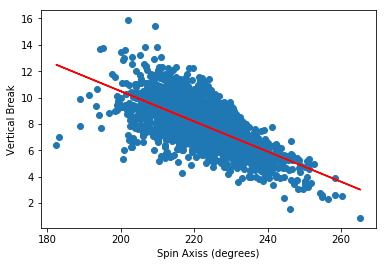

Scherzer 2016
Average Spin Rate = 2070.1345029239765
Average Spin Axis = 212.4268849902534
Average Vertical Break = 8.550597038972708


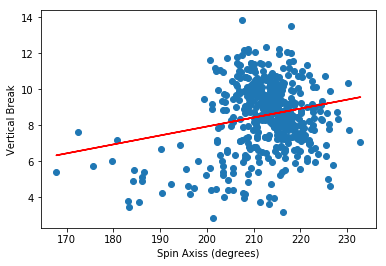

In [691]:
n=2011
for i in ff:
    plt.xlabel("Spin Axiss (degrees)")
    plt.ylabel("Vertical Break")
    plt.scatter(i['spin'],i['break_y'])
    print("Scherzer", n)
    print("Average Spin Rate =", i.tm_spin.mean())
    print("Average Spin Axis =",i['spin'].mean() )
    print("Average Vertical Break =",i['break_y'].mean())
    #print("Swing Miss % =", i['swingMiss'].mean())
    reg = linear_model.LinearRegression()
    reg.fit(i[['spin']], i['break_y'])
    plt.plot(i['spin'], reg.predict(i[['spin']]), color='red')
    plt.show()
    n+=5

###### Conclusion: The first thing that is noticable is the positive correlation in 2016 vs the negative correlation in 2011.  It is also important to notice that Scherzer gets the most vertical break, on average, at around 210 degrees.  In 2016, he is consistently closer to 210 degrees, even though it is a smaller sample size, since he threw more two seams in 2016.  With technology such as Rapsodo now-a-days, pitching coaches should try to give Scherzer cues to get his fastball to stay around 210 degrees.

Scherzer 2011
Average Spin Rate = 2122.074433656958
Average Velocity = 93.85866774541532
Average Vertical Break = 7.922699342966019
Average Vertical Location = 2.5047031626289105
Average Horizontal Location = -0.24987541735059332


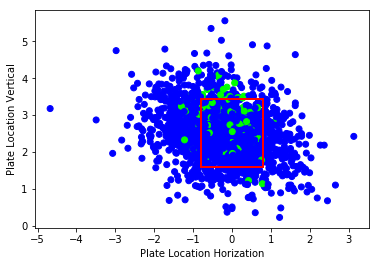

Scherzer 2016
Average Spin Rate = 2070.1345029239765
Average Velocity = 94.74423001949316
Average Vertical Break = 8.550597038972708
Average Vertical Location = 2.5166442314639372
Average Horizontal Location = 0.06531871047426901


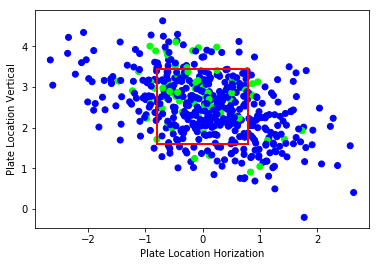

In [653]:
#Height of Strike Zone determined by averages of data set
n=2011
for i in ff:
    plt.xlabel("Plate Location Horization")
    plt.ylabel("Plate Location Vertical")
    plt.scatter(i['px'],i['pz'],c=i['swingMiss'],cmap=plt.cm.brg )
    plt.plot([.7915, .7915], [3.436, 1.594], 'k-', lw=2, color='r')
    plt.plot([-.7915, -.7915], [3.436, 1.594], 'k-', lw=2, color='r')
    plt.plot([-.7915, .7915], [3.436, 3.436], 'k-', lw=2, color='r')
    plt.plot([-.7915, .7915], [1.594, 1.594], 'k-', lw=2, color='r')
    print("Scherzer", n)
    print("Average Spin Rate =", i['tm_spin'].mean())
    print("Average Velocity =", i['start_speed'].mean())
    print("Average Vertical Break =",i['break_y'].mean())
    print("Average Vertical Location =", i['pz'].mean())
    print("Average Horizontal Location =", i['px'].mean())
    #print("Swing Miss % =", i['swingMiss'].mean())
    plt.show()
    n+=5


Scherzer 2011


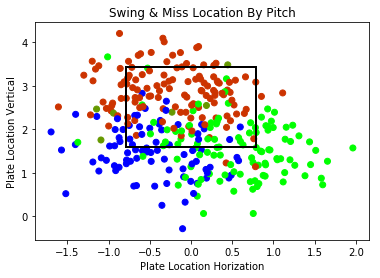

Scherzer 2016


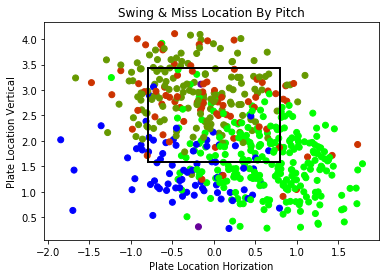

In [693]:
n=2011
for i in smissdfs:
    plt.xlabel("Plate Location Horization")
    plt.ylabel("Plate Location Vertical")   
    plt.title("Swing & Miss Location By Pitch")
    plt.plot([.7915, .7915], [3.436, 1.594], 'k-', lw=2, color='black')
    plt.plot([-.7915, -.7915], [3.436, 1.594], 'k-', lw=2, color='black')
    plt.plot([-.7915, .7915], [3.436, 3.436], 'k-', lw=2, color='black')
    plt.plot([-.7915, .7915], [1.594, 1.594], 'k-', lw=2, color='black')
    plt.scatter(i['px'],i['pz'],c=i['pitchLabels'],cmap=plt.cm.brg)
    print("Scherzer", n)
    plt.show()
    n+=5

## Decision Tree
#### Predicting  pitch type from batter stance, count, inning, previous pitch, and previous outcome

In [655]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydotplus

#### 2016

In [656]:
model = tree.DecisionTreeClassifier()

In [657]:
treeVars16 = m16[['pitchType', 'stand', 'count', 'inning', 'prevPitch1', 'prevOutcome1']]
inputs = treeVars16.drop('pitchType', axis='columns')
target = treeVars16['pitchType']

In [658]:
inputs['stand_n'] = le.fit_transform(inputs['stand'].astype(str))
inputs['count_n'] = le.fit_transform(inputs['count'].astype(str))
inputs['prevPitch1_n'] = le.fit_transform(inputs['prevPitch1'].astype(str))
inputs['prevOutcome1_n'] = le.fit_transform(inputs['prevOutcome1'].astype(str))

inputs_n = inputs.drop(['stand', 'count', 'prevPitch1', 'prevOutcome1'], axis='columns')


In [659]:
X = inputs_n
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.35443037974683544

##### Seems to predict correctly 36% - 42% of time for 2016

### 2011

In [660]:
model = tree.DecisionTreeClassifier()

In [661]:
treeVars11 = m11[['pitchType', 'stand', 'count', 'inning', 'prevPitch1', 'prevOutcome1']]
inputs = treeVars11.drop('pitchType', axis='columns')
target = treeVars11['pitchType']

In [662]:
inputs['stand_n'] = le.fit_transform(inputs['stand'].astype(str))
inputs['count_n'] = le.fit_transform(inputs['count'].astype(str))
inputs['prevPitch1_n'] = le.fit_transform(inputs['prevPitch1'].astype(str))
inputs['prevOutcome1_n'] = le.fit_transform(inputs['prevOutcome1'].astype(str))

inputs_n = inputs.drop(['stand', 'count', 'prevPitch1', 'prevOutcome1'], axis='columns')


In [663]:
X = inputs_n
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5061728395061729

##### Seems to predict correctly 46% - 52% of time for 2011

###### Conclusion: The decision tree model was a lot better at predicting pitches in 2011 than in 2016; suggesting that Scherzer's pitch selection was a lot more predictable for hitters in 2011, making him less effective.

## Random Forest + Confusion Matrix

In [664]:
treeVars11 = m11[['pitchType', 'stand', 'count', 'inning', 'prevPitch1', 'prevOutcome1']]
inputs = treeVars11.drop('pitchType', axis='columns')
target = treeVars11['pitchType']

inputs['stand_n'] = le.fit_transform(inputs['stand'].astype(str))
inputs['count_n'] = le.fit_transform(inputs['count'].astype(str))
inputs['prevPitch1_n'] = le.fit_transform(inputs['prevPitch1'].astype(str))
inputs['prevOutcome1_n'] = le.fit_transform(inputs['prevOutcome1'].astype(str))

inputs_n = inputs.drop(['stand', 'count', 'prevPitch1', 'prevOutcome1'], axis='columns')


In [665]:
X = inputs_n
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


In [666]:
from sklearn.ensemble import RandomForestClassifier

In [667]:
model = RandomForestClassifier(n_estimators = 100) #How many random forests were used
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5308641975308642

##### Seems to correctly predict 52% - 54% of time for 2011

In [668]:
y_predicted = model.predict(X_test)

In [669]:
from sklearn.metrics import confusion_matrix

In [670]:
cm = confusion_matrix(y_test, y_predicted)

Text(69.0, 0.5, 'Truth')

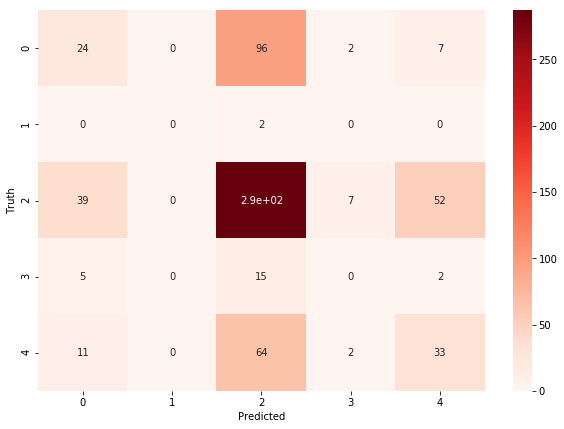

In [671]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot= True, cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# 0=CH, 1=FC, 2=FF, 3=FT, 4=SL

In [646]:
m11.pivot_table(index="pitchType", columns="pitchLabels", values="px")


pitchLabels,0,2,3,4,5
pitchType,,,,,
CH,-0.653454,NaN,NaN,NaN,NaN
FC,NaN,-1.131811,NaN,NaN,NaN
FF,NaN,NaN,-0.249875,NaN,NaN
FT,NaN,NaN,NaN,-0.231185,NaN
SL,NaN,NaN,NaN,NaN,0.358971


##### 2016


In [672]:
treeVars16 = m16[['pitchType', 'stand', 'count', 'inning', 'prevPitch1', 'prevOutcome1']]
inputs = treeVars16.drop('pitchType', axis='columns')
target = treeVars16['pitchType']

inputs['stand_n'] = le.fit_transform(inputs['stand'].astype(str))
inputs['count_n'] = le.fit_transform(inputs['count'].astype(str))
inputs['prevPitch1_n'] = le.fit_transform(inputs['prevPitch1'].astype(str))
inputs['prevOutcome1_n'] = le.fit_transform(inputs['prevOutcome1'].astype(str))

inputs_n = inputs.drop(['stand', 'count', 'prevPitch1', 'prevOutcome1'], axis='columns')


In [673]:
X = inputs_n
y = target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


In [674]:
model = RandomForestClassifier(n_estimators = 100) #How many random forests were used
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.43037974683544306

##### Seems to correctly predict 38% - 41% of time for 2016

In [675]:
y_predicted = model.predict(X_test)

In [676]:
from sklearn.metrics import confusion_matrix

In [677]:
cm = confusion_matrix(y_test, y_predicted)

Text(69.0, 0.5, 'Truth')

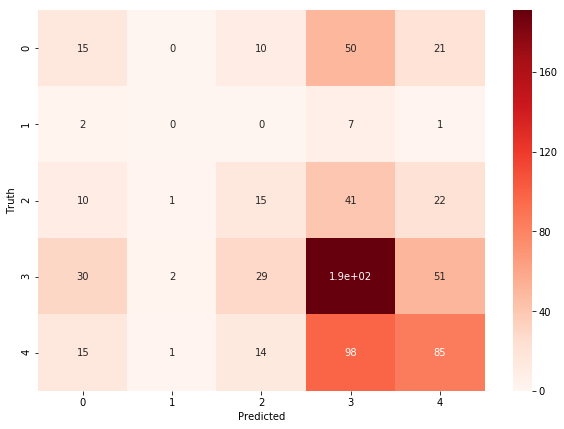

In [678]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot= True, cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# 0=CH, 1=FC, 2=FF, 3=FT, 4=SL

###### Conclusion: Once again, the Random Forest was a lot better at predicting pitch selection in 2011 vs 2016.  However, the Random Forest was slightly better than the Decision Tree, coming in at 53% vs 49% respectively, on average in 2011.  
###### Note: This was with 100 trees

## Support Vector Machine
##### Predicting pitch type based on velocity and spin rate

In [679]:
le = LabelEncoder()
m11['targetPitch'] = le.fit_transform(m11['pitchType'])
m16['targetPitch'] = le.fit_transform(m16['pitchType'])

/Users/bsnelson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bsnelson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [680]:
svdf0 = m11[m11.targetPitch == 0]
svdf1 = m11[m11.targetPitch == 1]
svdf2 = m11[m11.targetPitch == 2]
svdf3 = m11[m11.targetPitch == 3]
svdf4 = m11[m11.targetPitch == 4]

svdf5 = m16[m16.targetPitch == 0]
svdf6 = m16[m16.targetPitch == 1]
svdf7 = m16[m16.targetPitch == 2]
svdf8 = m16[m16.targetPitch == 3]
svdf9 = m16[m16.targetPitch == 4]

svdf11 = [svdf0,svdf1,svdf2,svdf3,svdf4]
svdf16 = [svdf5,svdf6,svdf7,svdf8,svdf9]
#svdf1.head()

In [681]:
from sklearn.model_selection import train_test_split

In [682]:
X = m11[['tm_spin', 'start_speed']]
y = m11.targetPitch

In [683]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [684]:
from sklearn.svm import SVC
model = SVC(C=3) #C is default =1. C = regularization

In [685]:
model.fit(X_train, y_train)

/Users/bsnelson/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [686]:
model.score(X_test, y_test)

0.6990740740740741

##### SVM predicts pitch type based on velocity and spin rate about 70% of the time

In [687]:
from matplotlib import pyplot as plt
%matplotlib inline

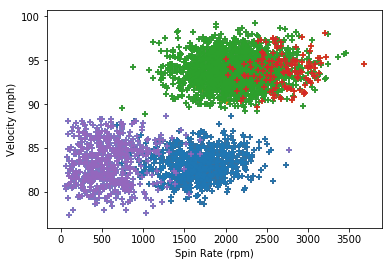

In [688]:
plt.xlabel('Spin Rate (rpm)')
plt.ylabel('Velocity (mph)')
for j in svdf16:
    for i in svdf11:
        plt.scatter(i['tm_spin'], i['start_speed'], marker='+')
        #plt.scatter(j['tm_spin'], j['start_speed'], marker='o')
        
     

Text(0.5, 1.0, 'Histogram of Spin Rate 2011 vs 2016')

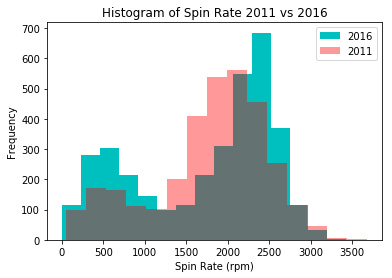

In [689]:
plt.hist(m16.tm_spin, bins=15, color="c")
plt.hist(m11.tm_spin, bins=15, color="r", alpha=.4)
plt.legend(["2016", "2011"])
plt.xlabel("Spin Rate (rpm)")
plt.ylabel("Frequency")
plt.title("Histogram of Spin Rate 2011 vs 2016")

In [690]:
df[(df['pitchType']=='FF') | (df['pitchType']=='FT') | (df['pitchType']=='FC')]

dateStamp  ab_count  batter_id        des type  sz_top  sz_bot  \
m11 0    2011-04-03         1     458731  Strikeout    S    3.06    1.53   
    1    2011-04-03         2     458731  Strikeout    S    3.20    1.53   
    2    2011-04-03         3     458731  Strikeout    S    3.17    1.50   
    3    2011-04-03         1     116539  Groundout    B    3.60    1.79   
    4    2011-04-03         2     116539  Groundout    S    3.54    1.67   
    5    2011-04-03         3     116539  Groundout    S    3.46    1.65   
    6    2011-04-03         4     116539  Groundout    S    3.45    1.79   
    7    2011-04-03         5     116539  Groundout    B    3.52    1.71   
    8    2011-04-03         6     116539  Groundout    B    3.44    1.59   
    9    2011-04-03         7     116539  Groundout    X    3.45    1.79   
    10   2011-04-03         1     407893     Single    B    3.35    1.61   
    11   2011-04-03         2     407893     Single    B    3.38    1.61   
    12   2011-04-03         3     407893     Single    X    3.28    1.51   
    13   2011-04-03         1     121347    Lineout    S    3.30    1.59   
    15   2011-04-03         3     121347    Lineout    X    3.47    1.62   
    16   2011-04-03         1     429664  Groundout    S    3.37    1.64   
    18   2011-04-03         3     429664  Groundout    B    3.55    1.60   
    20   2011-04-03         1     430897     Single    X    3.17    1.49   
    21   2011-04-03         1     120691   Home Run    X    3.44    1.75   
    22   2011-04-03         1     434158  Strikeout    B    3.30    1.56   
    26   2011-04-03         5     434158  Strikeout    S    3.32    1.71   
    27   2011-04-03         1     431145     Single    S    3.30    1.59   
    31   2011-04-03         5     431145     Single    B    3.22    1.55   
    32   2011-04-03         6     431145     Single    X    3.19    1.48   
    33   2011-04-03         1     458731   Forceout    B    3.17    1.45   
    34   2011-04-03         2     458731   Forceout    X    3.18    1.41   
    35   2011-04-03         1     116539  Groundout    S    3.58    1.79   
    37   2011-04-03         1     407893   Home Run    B    3.57    1.46   
    41   2011-04-03         3     121347  Strikeout    B    3.58    1.74   
    44   2011-04-03         6     121347  Strikeout    S    3.56    1.74   
...             ...       ...        ...        ...  ...     ...     ...   
m16 3484 2016-10-02         3     543329  Strikeout    S    3.53    1.53   
    3487 2016-10-02         2     588751     Flyout    S    3.21    1.48   
    3490 2016-10-02         5     588751     Flyout    B    3.31    1.48   
    3491 2016-10-02         6     588751     Flyout    X    3.31    1.48   
    3492 2016-10-02         1     543408  Strikeout    S    3.60    1.48   
    3495 2016-10-02         4     543408  Strikeout    S    3.23    1.48   
    3497 2016-10-02         2     543829     Single    B    3.32    1.41   
    3504 2016-10-02         5     542513  Groundout    X    3.01    1.55   
    3506 2016-10-02         2     445988    Lineout    X    3.39    1.48   
    3511 2016-10-02         1     571506       Walk    B    3.71    1.67   
    3515 2016-10-02         5     571506       Walk    B    3.60    1.67   
    3516 2016-10-02         6     571506       Walk    B    3.67    1.67   
    3518 2016-10-02         2     489305  Strikeout    S    3.54    1.72   
    3519 2016-10-02         3     489305  Strikeout    B    3.54    1.72   
    3521 2016-10-02         5     489305  Strikeout    S    3.61    1.72   
    3523 2016-10-02         1     543329   Home Run    B    3.61    1.53   
    3524 2016-10-02         2     543329   Home Run    X    3.57    1.53   
    3526 2016-10-02         2     588751    Lineout    S    3.35    1.48   
    3527 2016-10-02         3     588751    Lineout    S    3.42    1.48   
    3532 2016-10-02         2     400085     Single    B    3.42    1.47   
    3533 2016-10-02         3     400085     Single    S  